In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import scipy.stats as stats

import scipy
import pywt
import mne
import math

import sys
from tqdm import tqdm


sys.path.append('../utils')
from ERP_utils import *
from update_sub_lists import *
from wavelet_utils import *
from stats_utils import *
import glob
import os


import seaborn as sns
import warnings

# Suppress all FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Wavelet for multiple subjects listen and motor

In [2]:
task = 'listen'
ch_to_visualize = ['Cz']

wavelet_dir = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/wavelet/wavelets_mat_{task}__n05to05_30Hz_all_ave_freq'
subjects_to_process = find_existing_subjects(wavelet_dir)

good_listen_subjects, good_motor_subjects, musicians, nonmusicians = load_subject_lists()

print('processing subjects', subjects_to_process)

wavelet_trans_info = loadmat(os.path.join(wavelet_dir,f'wavelet_record.mat'))
times = wavelet_trans_info['times'].squeeze()
freqs = wavelet_trans_info['freqs'].squeeze()

processing subjects ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21']


##### Initialize directories

In [3]:
"""period = 'pre'
task = 'listen'
channels = 'Cz'"""

power_df_all = power_over_subs(subjects_to_process, wavelet_dir, freqs_to_sum='all', already_ave=True, ch_to_process = ch_to_visualize)

power_all_pre = power_df_all.query("period == 'pre'")
power_all_post = power_df_all.query("period == 'post'")

wavelet sub shape: (40, 129)
skipping sub record


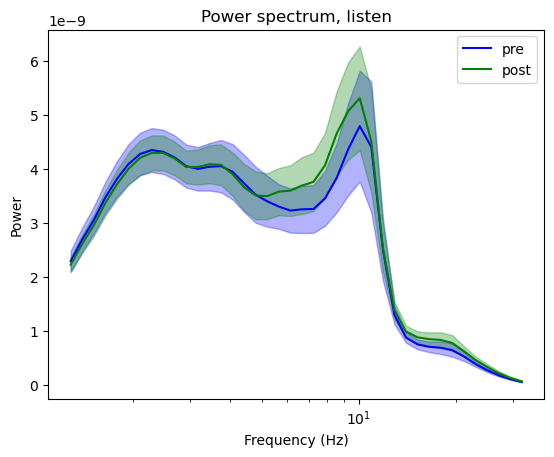

In [4]:
plot_power_freqs(freqs, power_all_pre, color = 'blue', label = 'pre')
plot_power_freqs(freqs, power_all_post, color = 'green', label = 'post')
plt.title(f'Power spectrum, {task}')
plt.legend()


Difference in power

In [5]:
power_diff = power_all_post['power']-power_all_pre['power']
power_diff = np.vstack(power_diff)

Text(0.5, 1.0, 'listen difference post-pre, good musicians')

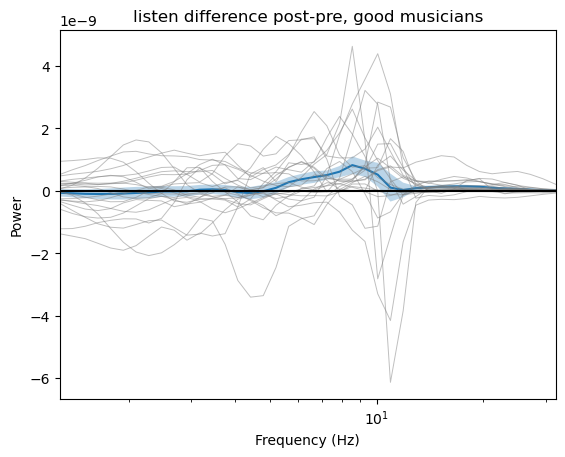

In [6]:
plot_power_freqs(freqs,power_diff)
for sub in range(power_diff.shape[0]):
    plt.plot(freqs, power_diff[sub, :], color = 'grey', alpha = 0.5, linewidth = 0.7)
plt.hlines(0,freqs[-1], freqs[0], color = 'black')
plt.xlim(freqs[-1], freqs[0])
plt.title(f'{task} difference post-pre, good musicians')

In [7]:
freq_to_test_low = 5
freq_to_test_high = 30

lim1 = index_custom([freq_to_test_low],freqs)[0]
lim2 = index_custom([freq_to_test_high], freqs)[0]
test_stats, p_values = t_within_points(power_diff, lim1=lim1, lim2=lim2)

testing gaussianity over 21 points
Distribution is not normal. p =  2.2241191184921992e-05
using wilcoxon test
fdr correction over 22 points


testing gaussianity over 21 points
Distribution is not normal. p =  2.2241191184921992e-05
using wilcoxon test
fdr correction over 22 points


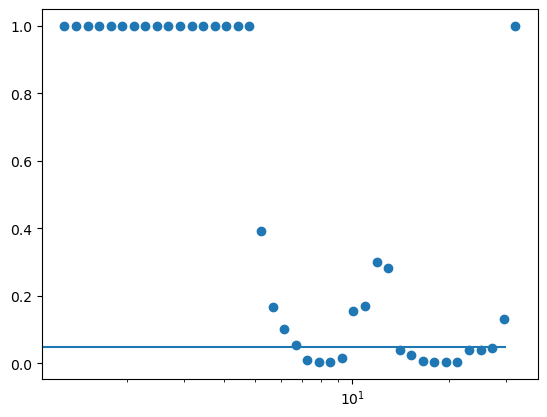

In [8]:
test_stats, p_values = t_within_points(power_diff, lim1=lim1, lim2=lim2)
plt.scatter(freqs, p_values)
plt.hlines(0.05, 0, 30)
plt.xscale('log')

Text(0.5, 1.0, 'listen difference post-pre (all subjects)')

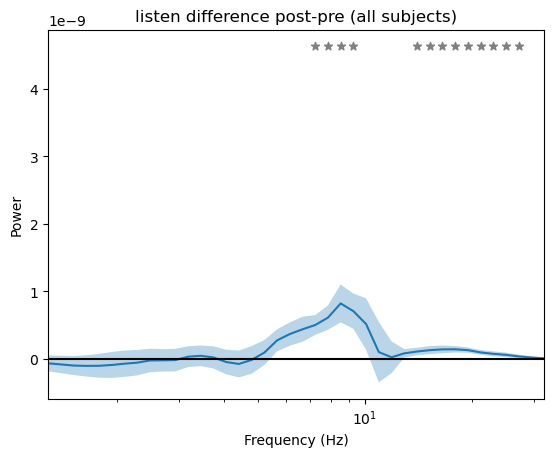

In [9]:
sig_idx = [i for i, p in enumerate(p_values) if p < 0.05]

plot_power_freqs(freqs, power_diff)
plt.hlines(0,freqs[-1], freqs[0], color = 'black')
plt.xlim(freqs[-1], freqs[0])

sig_y_pos = np.max(power_diff)
plt.scatter(freqs[sig_idx], [sig_y_pos]*len(sig_idx), marker = "*", color = 'grey')
plt.title(f'{task} difference post-pre (all subjects)')

bootstrap/jackknife

In [10]:
def jackknife_1samp(data_point, test):
    """
    estimate distribution of p values (also test statistics)
    data_freq: data of shape n_subs, already indexed for the freq or timepoint of interest
    test: which test to do. Usually wilcoxon

    ---
    returns:
    p_vals: distribution of p values
    ---
    """
    n_subs = data_point.shape[0]

    t_stat_jk = []
    p_val_jk = []
    
    for sub in range(n_subs):
        data_resampled = np.delete(data_point, sub)
        res = test(data_resampled)
        p_val_jk.append(res.pvalue)
        t_stat_jk.append(res.statistic)

    return t_stat_jk, p_val_jk

In [11]:

p_distr_all = []
for freq in range(power_diff.shape[1]):
    _, p_vals = jackknife_1samp(power_diff[:, freq], test= wilcoxon)
    p_distr_all.append(p_vals)
p_distr_all = np.array(p_distr_all)

Text(0.5, 0, 'freqs')

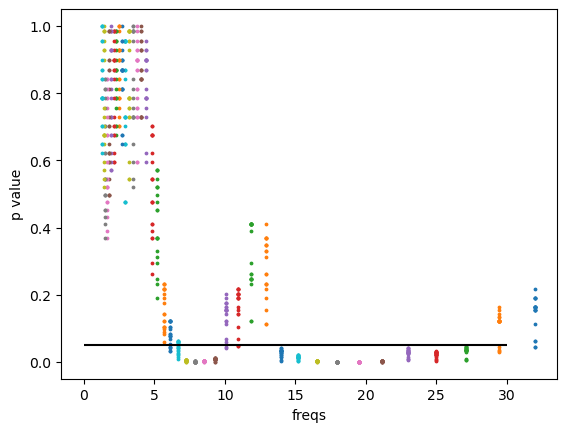

In [12]:
for i, freq in enumerate(freqs): 
    plt.scatter([freq]*p_distr_all.shape[1], p_distr_all[i], s = 3)

plt.hlines(0.05, 0,30, color = 'black')
plt.ylabel('p value')
plt.xlabel('freqs')

### Violin plots of pre and post

In [13]:
#TO DO??

power_df_610 = power_over_subs(subjects_to_process, wavelet_dir, already_ave=True, freqs_to_sum=[7.2,9.3], ch_to_process = ['Cz'])
power_df_1230 = power_over_subs(subjects_to_process, wavelet_dir, already_ave=True, freqs_to_sum=[12,30], ch_to_process = ['Cz'])

wavelet sub shape: (40, 129)
skipping sub record
wavelet sub shape: (40, 129)
skipping sub record


In [14]:
def find_power_diff(power_df):
    """ 
    Finds post-pre values for a given power dataframe
    ---
    Returns a dataframe with pre, post, and difference
        TO DO: get rid of the pre and post to save on memory??
    """
    power_pivot = power_df.pivot(index =[ 'subject', 'musician'], columns = 'period', values = 'power')
    power_pivot['diff'] = power_pivot['post'] - power_pivot['pre']
    return power_pivot

In [15]:
power_diff_610 = find_power_diff(power_df_610)
power_diff_1230 = find_power_diff(power_df_1230)

In [16]:
def plot_power_bands(power_df_band):
    plt.figure(figsize=(3,4))
    sns.set_palette('rocket_r')

    # Specify the order of categories
    order = ['pre', 'post']

    # Violin plot
    sns.violinplot(data=power_df_band, x='period', y='power', order=order)

    # Strip plot
    sns.stripplot(data=power_df_band, x='period', y='power', color='black', order=order, jitter = False)

    # Add connecting lines
    for subject in power_df_band['subject'].unique():
        subject_data = power_df_band[power_df_band['subject'] == subject]
        plt.plot(subject_data['period'], subject_data['power'], marker='o', color='grey', alpha=0.5, linewidth=0.5)



Text(0.5, 1.0, 'listen power over 6-10 Hz')

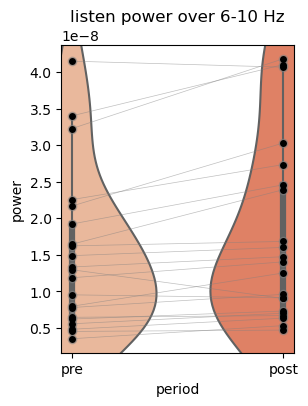

In [17]:
plot_power_bands(power_df_610)
#plt.ylim(-1e-8, 8e-8)
#plt.xlim(-1,2)
plt.title(f"{task} power over 6-10 Hz")

### Correlate with musical ability

In [33]:
def diff_score_df(power_diff_df, scores_df): 

    """ 
    combines the df with training scores and the df with differences in power at a certain freq band

    Note: subject is the unformatted column. sub is formatted as strings with leading 0s, e.g. '02'
    power_diff_df: expected columns: sub, diff
    scores_df: exported from training repo with scores from all subjects. Expected columns:  subject, score, musician, rank
    
    ---
    returns: power_diff_df_ranked, df with sub, relative ranking to other subjects
    """

    #configure sub column of scores_df to make it match the column in the diff df
    scores_df['sub'] = scores_df['subject'].astype(int).apply(lambda x: f'{x:02d}')

    #configure power_diff_df
    power_diff_df['sub'] = power_diff_df.index
    power_diff_df['sub'] = power_diff_df['sub'].apply(lambda x: x[0])
    power_diff_filt_df = power_diff_df[['sub', 'diff']]
    power_diff_filt_df.reset_index(drop=True)

    power_diff_df_ranked = power_diff_filt_df.merge(scores_df, on =[ 'sub'])
    #power_diff_df_ranked = power_diff_df_ranked[['sub', 'diff', 'musician', 'score', 'rank']]

    return power_diff_df_ranked



In [ ]:
exclude_subs = []

scores_df = pd.read_csv('/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/utils/training_scores_rank.csv')


In [41]:
scores_df

,Unnamed: 0,subject,score,musician,rank
0,0,13,3.903614,1,1
1,1,18,3.855422,1,2
2,2,15,3.783133,1,3
3,3,2,3.698795,1,4
4,4,12,3.674699,1,5
5,5,3,3.469880,0,6
6,6,17,3.421687,1,7
7,7,14,3.409639,1,8
8,8,10,3.373494,0,9
9,9,9,3.325301,0,10


In [42]:
power_diff_ranked = diff_score_df(power_diff_610, scores_df)

power_diff_ranked = power_diff_ranked[~power_diff_ranked['sub'].isin(exclude_subs)]


In [43]:
power_diff_ranked

,sub,diff,Unnamed: 0,subject,score,musician,rank
0,01,1.792679e-09,16,1,2.602410,0,17
1,02,4.793688e-09,3,2,3.698795,1,4
2,03,7.458711e-09,5,3,3.469880,0,6
3,04,1.447374e-09,19,4,2.192771,0,20
4,05,-3.927328e-09,17,5,2.313253,0,18
5,06,6.069575e-10,12,6,3.060241,1,13
6,07,2.172247e-09,11,7,3.180723,1,12
7,08,1.408437e-09,13,8,3.036145,0,14
8,09,2.336531e-10,9,9,3.325301,0,10
9,10,1.519269e-09,8,10,3.373494,0,9


In [44]:
#linear regression
slope, intercept, r_value, p_value_corr, std_err = stats.linregress(power_diff_ranked['score'], power_diff_ranked['diff'])


In [45]:
stats.spearmanr(power_diff_ranked['score'], power_diff_ranked['diff'])

SignificanceResult(statistic=0.42987012987012985, pvalue=0.051781881711895544)

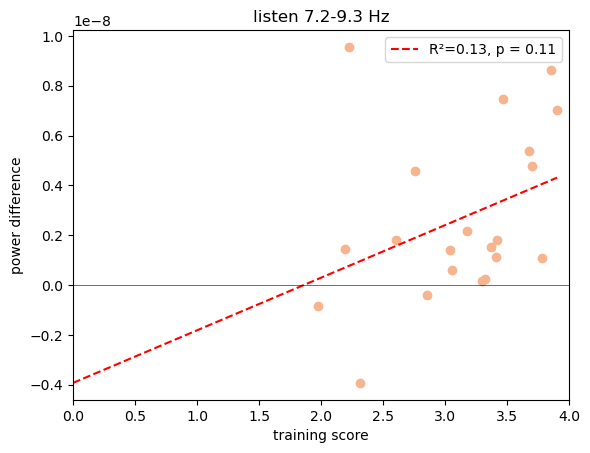

In [47]:

# Scatter plot
plt.scatter(power_diff_ranked['score'], power_diff_ranked['diff'])

# Generate the regression line
x = np.linspace(0, max(power_diff_ranked['score']), 100)
y = slope * x + intercept
plt.plot(x, y, color='red', label=f'R²={r_value**2:.2f}, p = {p_value_corr:.2f}', linestyle = '--')


# Add labels and legend
plt.xlabel('training score')
plt.ylabel('power difference')
plt.legend()
plt.title(f'{task} 7.2-9.3 Hz')
plt.xlim(0,4)
#plt.ylim(-10,10)
plt.hlines(0, 0,4, color = 'black', linewidth=0.4)
plt.show()





Jackknife for correlation

In [48]:
#linear regression
slope, intercept, r_value, p_value_corr, std_err = stats.linregress(power_diff_ranked['score'], power_diff_ranked['diff'])
print(f'r2: {r_value**2}, p value: {p_value_corr}')

r2: 0.12956201001761034, p value: 0.10899218661732468


In [ ]:
from scipy.stats import norm, pearsonr, spearmanr

def jackknife_corr(x, y, alpha=0.05, test = pearsonr):
    """
    Perform jackknife estimation for the correlation coefficient.
    
    Parameters:
        x (array-like): Array of x values.
        y (array-like): Array of y values.
        alpha (float): Significance level for confidence intervals (default is 0.05).
        
    Returns:
        p (float): p-value of the observed correlation.
        ci (tuple): Confidence interval for the correlation coefficient.
    """
    # Observed correlation coefficient
    obs_corr, obs_p = test(x, y)
    
    # Number of observations
    n = len(x)
    
    # Jackknife correlation estimates
    jack_corr = np.zeros(n)
    p_corr = np.zeros(n)
    for i in range(n):
        # Leave-one-out samples
        loo_x = np.delete(x, i)
        loo_y = np.delete(y, i)
        # Calculate correlation for each leave-one-out sample
        jack_corr[i], p_corr[i] = test(loo_x, loo_y)
    
    # Calculate bias and variance
    bias_est = (n - 1) * (np.mean(jack_corr) - obs_corr)
    var_est = ((n - 1) / n) * np.sum((jack_corr - np.mean(jack_corr))**2)
    
    # Calculate z-score and p-value
    z = obs_corr / np.sqrt(var_est)
    p = 2 * norm.cdf(-abs(z))
    
    # Custom significance level
    z_critical = abs(norm.ppf(alpha / 2))  # Z-score for two-tailed test
    
    # Confidence interval
    ci_lower = obs_corr - z_critical * np.sqrt(var_est)
    ci_upper = obs_corr + z_critical * np.sqrt(var_est)
    ci = (ci_lower, ci_upper)
    
    # Display results
    print('Jackknife Estimates:')
    print(f'Correlation coefficient (all data): {obs_corr}')
    print(f'p-value (all data): {obs_p}')
    print(f'p-value: {p}')
    print(f'Bias estimate: {bias_est}')
    print(f'Variance estimate: {var_est}')
    print(f'{100 * (1 - alpha)}% Confidence Interval: [{ci[0]}, {ci[1]}]')
    
    return p, ci, jack_corr, p_corr



In [53]:
x = np.random.rand(50)
y = np.random.rand(50)
alpha = 0.05

p, ci, jack_corr, p_corr = jackknife_corr(power_diff_ranked['score'], power_diff_ranked['diff'], alpha, test = pearsonr)


Jackknife Estimates:
Correlation coefficient (all data): 0.3599472322683013
p-value (all data): 0.10899218661732461
p-value: 0.25146648755359546
Bias estimate: 0.008587312296463034
Variance estimate: 0.09851590158034373
95.0% Confidence Interval: [-0.2552314239807968, 0.9751258885173993]


(0.0, 1.0)

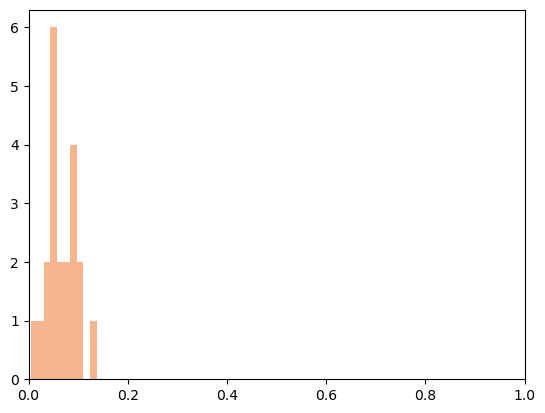

In [50]:
plt.hist(p_corr)
plt.xlim(0,1)

Bootstrap

In [56]:
def bootstrap_corr(B, x, y, alpha=0.05, test = pearsonr):
    """
    Compute bootstrap confidence intervals and p-value for the correlation coefficient.

    Parameters:
    - B: int, number of bootstrap samples (e.g., B=1000)
    - x: array-like, first variable
    - y: array-like, second variable
    - alpha: float, significance level (e.g., alpha=0.05)

    Returns:
    - p: float, p-value for the observed correlation coefficient
    - ci: tuple, confidence interval for the correlation coefficient
    """
    # Observed correlation coefficient
    obs_corr, obs_p = test(x, y)

    # Bootstrap resampling
    n = len(x)
    boot_corr = np.empty(B)
    p_corr = np.empty(B)
    for i in range(B):
        indices = np.random.choice(n, n, replace=True)
        boot_corr[i], p_corr[i] = test(x[indices], y[indices])

    # Calculate confidence interval
    ci = np.percentile(boot_corr, [100 * alpha / 2, 100 * (1 - alpha / 2)])

    # Calculate p-value
    p = 2 * min(np.mean(boot_corr >= obs_corr), np.mean(boot_corr <= -obs_corr))

    # Calculate p-value
    #p_upper = np.mean(boot_corr >= obs_corr)
    #p_lower = np.mean(boot_corr <= -obs_corr)
    #p = p_upper + p_lower  # Combine both tails


    # Plot histogram of bootstrap correlations
    plt.figure()
    plt.hist(boot_corr, bins=30, color='blue', alpha=0.7, edgecolor='black')
    plt.axvline(obs_corr, color='red', linewidth=2, label=f'Sample Correlation ({obs_corr:.3f})')
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Frequency')
    plt.title('Bootstrap Distribution of Correlation')
    plt.legend()
    plt.show()

    # Display results
    print('Bootstrap Estimates:')
    print(f'Correlation coefficient: {obs_corr:.3f}, p = {obs_p}')
    print(f'p-value: {p:.7f}')
    print(f'{(1 - alpha) * 100:.1f}% Confidence Interval: [{ci[0]:.3f}, {ci[1]:.3f}]')
    print(f'bootstrap corr: {boot_corr.mean()}, ave_p = {p_corr.mean()}')

    return p, ci, boot_corr, p_corr



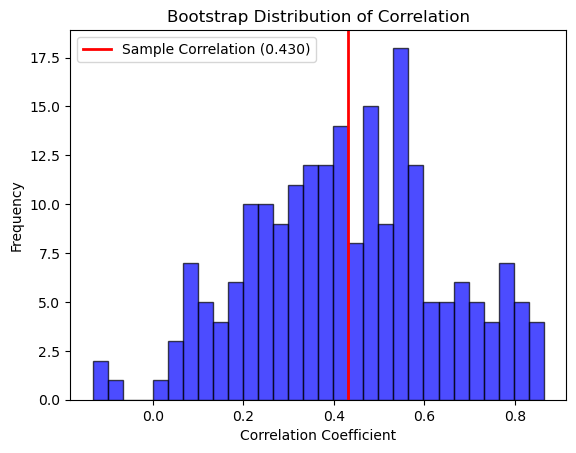

Bootstrap Estimates:
Correlation coefficient: 0.430, p = 0.051781881711895544
p-value: 0.0000000
95.0% Confidence Interval: [0.054, 0.819]
bootstrap corr: 0.4298777534640676, ave_p = 0.15408006416321435


In [90]:

p, ci, boot_corr, p_corr = bootstrap_corr(210, power_diff_ranked['score'], power_diff_ranked['diff'], alpha=0.05, test =spearmanr)

In [ ]:
import numpy as np
from scipy.stats.mstats import winsorize, pearsonr

# Winsorize data (trim extreme values)
x_wins = winsorize(power_diff_ranked['score'], limits=[0.05, 0.05])  # 5% limits
y_wins = winsorize(power_diff_ranked['diff'], limits=[0.05, 0.05])

# Compute Pearson correlation on Winsorized data
corr, p_value = pearsonr(x_wins, y_wins)
print(f"Winsorized correlation: {corr:.3f}, p-value: {p_value:.3e}")


Winsorized correlation: 0.339, p-value: 1.332e-01
